# Grizzlies Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 28, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 27 # grizzlies

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6328 entries, 0 to 6327
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              6328 non-null   int64  
 1   dimCustomerMasterId       6328 non-null   int64  
 2   customerNumber            6328 non-null   object 
 3   year                      6328 non-null   object 
 4   productGrouping           6328 non-null   object 
 5   totalSpent                6328 non-null   float64
 6   recentDate                6328 non-null   object 
 7   attendancePercent         6328 non-null   float64
 8   renewedBeforeDays         6292 non-null   float64
 9   isBuyer                   6328 non-null   object 
 10  source_tenure             6328 non-null   int64  
 11  tenure                    6292 non-null   float64
 12  distToVenue               6328 non-null   float64
 13  totalGames                6328 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6328 entries, 0 to 6327
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          6328 non-null   int64  
 1   dimCustomerMasterId   6328 non-null   int64  
 2   customerNumber        6328 non-null   object 
 3   year                  6328 non-null   object 
 4   productGrouping       6328 non-null   object 
 5   totalSpent            6328 non-null   float64
 6   recentDate            6328 non-null   object 
 7   attendancePercent     6328 non-null   float64
 8   renewedBeforeDays     6292 non-null   float64
 9   isBuyer               6328 non-null   object 
 10  source_tenure         6328 non-null   int64  
 11  tenure                6292 non-null   float64
 12  distToVenue           6328 non-null   float64
 13  totalGames            6328 non-null   int64  
 14  recency               6328 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (5695, 47)
Unseen Data For Predictions: (633, 47)
Data for Modeling (A Class): (5695, 47)
Unseen Data For Predictions: (633, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(6328, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6328 entries, 0 to 6327
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6328 non-null   int64  
 1   totalSpent           6328 non-null   float64
 2   attendancePercent    6328 non-null   float64
 3   source_tenure        6328 non-null   int64  
 4   tenure               6292 non-null   float64
 5   totalGames           6328 non-null   int64  
 6   missed_games_1       6328 non-null   int64  
 7   missed_games_2       6328 non-null   int64  
 8   missed_games_over_2  6328 non-null   int64  
 9   isNextYear_Buyer     6328 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 494.5 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,-0.05,0.09,0.53,0.19,0.08,0.07,0.06,0.10,0.14
totalSpent,-0.05,1.00,-0.15,-0.02,0.15,0.40,0.10,0.16,0.39,0.14
attendancePercent,0.09,-0.15,1.00,0.08,-0.26,0.32,0.35,0.20,-0.16,0.12
source_tenure,0.53,-0.02,0.08,1.00,0.14,0.09,0.07,0.06,0.08,0.13
tenure,0.19,0.15,-0.26,0.14,1.00,0.01,-0.01,-0.00,0.01,0.05
totalGames,0.08,0.40,0.32,0.09,0.01,1.00,0.68,0.57,0.54,0.38
missed_games_1,0.07,0.10,0.35,0.07,-0.01,0.68,1.00,0.52,0.26,0.27
missed_games_2,0.06,0.16,0.20,0.06,-0.00,0.57,0.52,1.00,0.35,0.27
missed_games_over_2,0.10,0.39,-0.16,0.08,0.01,0.54,0.26,0.35,1.00,0.34
isNextYear_Buyer,0.14,0.14,0.12,0.13,0.05,0.38,0.27,0.27,0.34,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5062, 10)
Unseen Data For Predictions: (1266, 10)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "totalSpent",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,3454
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5062, 10)"
5,Missing Values,True
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


([<pandas.io.formats.style.Styler at 0x7fd003830890>],
 Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 785     1
 1923    0
 959     1
 3960    1
 2562    0
        ..
 3518    1
 612     1
 1516    1
 1300    0
 1111    0
 Name: isNextYear_Buyer, Length: 4049, dtype: int64,
 False,
 600     0
 2481    0
 3912    1
 1914    1
 4908    1
        ..
 3579    1
 163     1
 1937    0
 1169    1
 2818    1
 Name: isNextYear_Buyer, Length: 1013, dtype: int64,
 False,
 -1,
       dimCustomerMasterId  totalSpent  attendancePercent  source_tenure  \
 0               352020642      1800.0           0.000000           1095   
 1               352026719        50.0           1.000000           1095   
 2               352032713      1170.0           0.777778           1095   
 3               352013481       648.0           0.000000           1095   
 4               323076948       357.0           0.333333           1095   
 ...                   ...         ...    

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.7409,0.8202,0.7861,0.7202,0.7510,0.4821,0.4853,0.1000
8,NGBClassifier,0.7407,0.8195,0.7906,0.7177,0.7517,0.4816,0.4852,1.3730
5,Light Gradient Boosting Machine,0.7377,0.8083,0.7836,0.7174,0.7485,0.4757,0.4786,0.0350
7,Random Forest Classifier,0.7328,0.8072,0.7836,0.7107,0.7450,0.4658,0.4688,0.2460
9,Extreme Gradient Boosting,0.7271,0.8024,0.7663,0.7100,0.7365,0.4544,0.4566,0.3680
0,Ada Boost Classifier,0.7204,0.8070,0.7419,0.7105,0.7251,0.4410,0.4425,0.0470
3,Extra Trees Classifier,0.7187,0.7909,0.7732,0.6963,0.7324,0.4377,0.4408,0.2130
1,Decision Tree Classifier,0.6663,0.6663,0.6600,0.6662,0.6626,0.3326,0.3331,0.0100
4,K Neighbors Classifier,0.6154,0.6467,0.6457,0.6076,0.6253,0.2312,0.2323,0.0490
6,Logistic Regression,0.5520,0.5905,0.2906,0.4226,0.3440,0.1022,0.1076,0.0080


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7704,0.8501,0.8168,0.7466,0.7801,0.5408,0.5432
1,0.7679,0.8336,0.8020,0.7500,0.7751,0.5359,0.5372
2,0.7605,0.8587,0.8515,0.7197,0.7800,0.5212,0.5301
3,0.7432,0.8353,0.7624,0.7333,0.7476,0.4865,0.4868
4,0.7111,0.7901,0.7079,0.7114,0.7097,0.4222,0.4222
5,0.7580,0.8424,0.7761,0.7464,0.7610,0.5162,0.5166
6,0.7457,0.8217,0.7562,0.7379,0.7469,0.4914,0.4916
7,0.7210,0.7988,0.8259,0.6803,0.7461,0.4428,0.4531
8,0.6914,0.7604,0.7463,0.6696,0.7059,0.3832,0.3857
9,0.7401,0.8106,0.8159,0.7069,0.7575,0.4806,0.4863


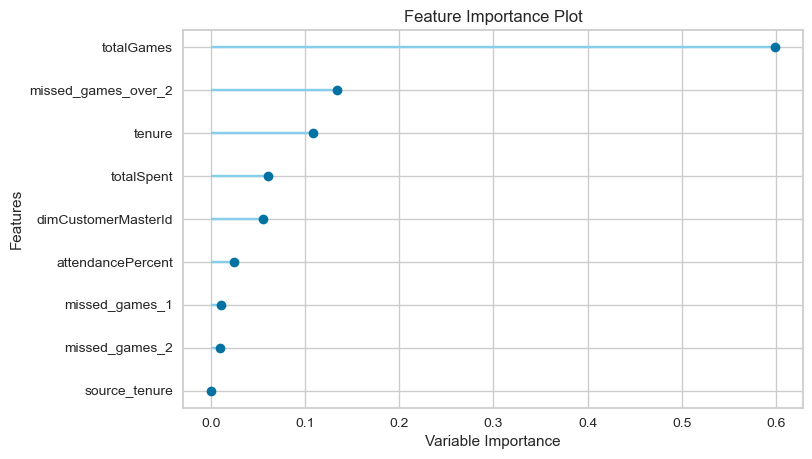

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?